
# Mapping Palisades and Eaton fires (January 2025)
## Peter Vitale

### Github Repo: https://github.com/petervitale910/eds220-hwk4

## About this notebook 
In this project we will be using true and false color imagery to examine the impacts of two fires which struck the Los Angeles area in early 2025. 

### Highlights: 
- Extracting color bands from xarray
- Mapping using true and false color imagery
- Overlaying fire perimiters to see effect of fires

### About the data: 

#### Palisades and Eaton fire perimeters 
These contain dissolved fire perimeters/boundaries for Eaton and Palisades fires, with boundary polygons dissolved for each fire to create a single fire burn perimeter. Access given by the County of Los Angeles.

#### Netcdf landsat data
Landsat C2 L2 from Microsoft's Planetary Computer is a globally available, multi-decadal archive of atmospherically corrected, analysis-ready Landsat imagery. Surface reflectance for multispectral bands and derived land surface temperature from thermal bands are provided in cloud-optimized GeoTIFFs, accessible via a STAC API. Accordingly, it is primarily used for long-term environmental monitoring, spectral studies, and thermal remote sensing, and is designed for scalable, cloud-native remote sensing workflows.

### References: 

- Los Angeles GeoHub / NIFC FIRIS. (2025). Palisades-Eaton dissolved fire perimeters [data filel. Available: https://geohub/.lacity.org/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about. [Accessed: Nov. 15, 2025]

- U.S. Geological Survey. Landsat Collection 2 Level-2 Surface Reflectance (Microsoft Planetary Computer version)  Idata file Available: https://planetarycomputer.microsoft.com/dataset/landsat-c2-12. [Accessed: Nov. 15, 2025]


In [68]:
import pandas as pd
import geopandas as gpd 
import matplotlib.pyplot as plt
import os 
import xarray as xr
import rioxarray as rio
import numpy as np 
from matplotlib_scalebar.scalebar import ScaleBar


## 2. Fire perimeter data exploration

Explore the fire perimeter data and write a brief summary of the information you obtained from the preliminary exploration. Your summary should include, at least, the CRS of the data and whether this is projected or geographic.

I am going to import both perimeters and then look at the CRS. 

In [2]:
fp = os.path.join('data','Eaton_Perimeter_20250121','Eaton_Perimeter_20250121.shp')
eaton_perimeter = gpd.read_file(fp)

In [3]:
fp = os.path.join('data','Palisades_Perimeter_20250121','Palisades_Perimeter_20250121.shp')
palisades_perimeter = gpd.read_file(fp)

In [4]:
# Now we can look at the crs's and do some exploration 
palisades_perimeter.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
eaton_perimeter.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
# Lets compare the column names to make sure they match 

print(f' It is {eaton_perimeter.columns == palisades_perimeter.columns} that he column names match')

 It is [ True  True  True  True  True] that he column names match


In [7]:
# Thats great we only need to look at one of the dataframes columns 

eaton_perimeter.columns

Index(['OBJECTID', 'type', 'Shape__Are', 'Shape__Len', 'geometry'], dtype='object')

In [8]:
# Might need some work 

*Summary:* From the preliminary exploration both the Palisades and Eaton datasets are in ESPG:3857, which is a projected coordinate system. Both have the same column names which will make analysis easier, however we may need to edit the column names, though none are incredibly bad (e.g having a space in the name). 

## 3. NetCDF data import and exploration
Import the Landsat data using `xr.open_dataset().`

Explore the data and write a brief summary of the information you obtained from the preliminary information. Your summary should include the a description of the data’s variables, dimensions, and coordinates.


In [9]:
netcdf = xr.open_dataset('data/landsat8-2025-02-23-palisades-eaton.nc')

In [10]:
netcdf

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...
    spatial_ref  int64 8B ...

This xarray has 1418 y dimensions and 2742 x dimensions. The coordinates are x, y, and time which are are float64, float64, and datetime64 types (respectively). The variables are red, green, blue, near infared and short wave infared light bands as well as a spatial reference. The bands are in float32 while the spatial_ref is an int64, this shouldn't be an issue going further - however as the analysis continues it may become an issue. 

## 4. Restoring geospatial information
Use rio.crs to print what is the CRS of this dataset. Is this a geospatial object?

You may have noticed on section 3 that the geospatial information for this dataset is stored in the variable spatial_ref. Print the CRS by using accesing the spatial_ref.crs_wkt attribute of the dataset.

Recover the geospatial information by using rio.write_crs() and the spatial reference information form part b.

Print the CRS of the updated dataset.



In [11]:
print(f'The xarray has the crs: {netcdf.rio.crs}')


The xarray has the crs: None


Oh no! Theres no crs meaning that it will be harder to plot, however there actually is! It's just encoded in the `spatial_ref` variable. 

In [12]:
print(f' The actual crs of the xarray is: {netcdf.spatial_ref.crs_wkt}')

 The actual crs of the xarray is: PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]


*Oh wow thats big!* Lets make it so that crs is the crs for the dataset

In [13]:
netcdf = netcdf.rio.write_crs(netcdf.spatial_ref.crs_wkt) # Need to write_crs due to being an xarrray

In [14]:
print(f'The xarray now has the crs: {netcdf.rio.crs}')


The xarray now has the crs: EPSG:32611


## 5. True color image
Without creating any new variables:
- select the red, green, and blue variables (in that order) of the xarray.Dataset holding the Landsat data,
- convert it to a numpy.array using the to_array() method, and then
- use .plot.imshow() to create an RGB image with the data. There will be two warnings, that’s ok.
- Adjust the scale used for plotting the bands to get a true color image. 

- To resolve the other warning, identify which bands have nan values. 

- Use the .fillna() mehtod for xarray.Datasets to substitute the any nan values in the Landsat data for zero.

- Create a new true color image that gets plotted without warnings.

- In a markdown cell write a brief explanation comparing the ouputs for parts (a) and (e).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


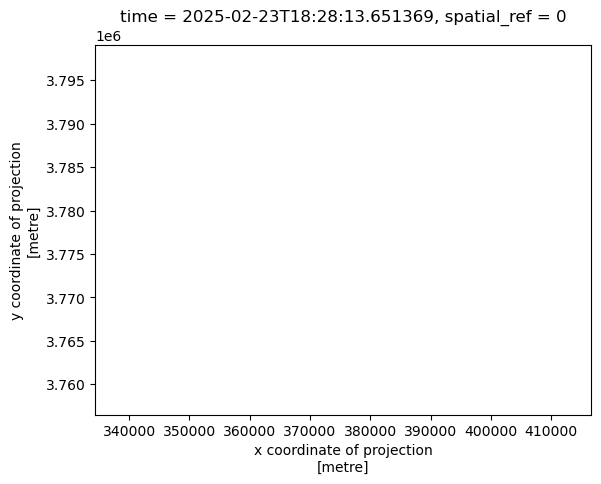

In [15]:
netcdf[['red', 'green', 'blue']].to_array().plot.imshow() # Plot red, green and blue bands

In [16]:
print(f'The red band has {np.isnan(netcdf.red).sum().item()} na values')
print(f'The green band has {np.isnan(netcdf.green).sum().item()} na values')
print(f'The blue band has {np.isnan(netcdf.blue).sum().item()} na values')

The red band has 0 na values
The green band has 1 na values
The blue band has 109 na values


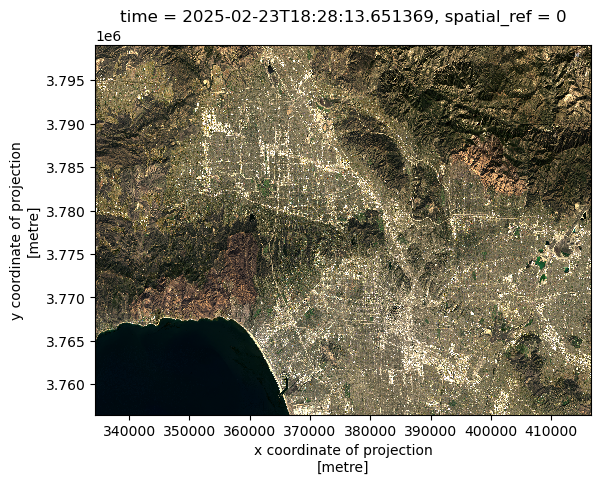

In [17]:
netcdf[['red', 'green', 'blue']].fillna(0).to_array().plot.imshow(robust = True) # Fillna and robust = true are the fix for the two problems

Explanation: 
The code for the two plots is relatively similar, however the first runs an error. This is because of two reasons: NA's and how the data is stored. As we saw in my f-prints there are a total of 110 NA Values. The data also contains some extreme outliers, which run into an error when plotting. By selecting `robust = TRUE`, the outlier values are minimized by using the second and 98th percentile of values to minimize outliers. Furthermore `fillna(0)` makes it so all our NA values become 0. 

## 6. False color image
Without creating any new variables, create a false color image by plotting the short-wave infrared (swir22), near-infrared, and red variables (in that order).

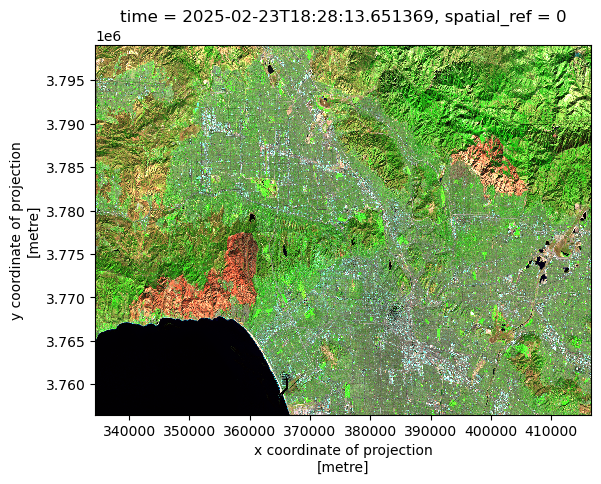

In [20]:
# This plotting code is very similar to the other, but we are selecting bands
netcdf[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True) # Note! No Na's are present

## 7. Map
Create a map showing the shortwave infrared/near-infrared/red false color image together with both fire perimeters. Customize it appropriately including, at least, an informative title and legend. You may also want to include text on the map to identify which fire is which.

Write a figure description for the map including a brief explanation of how false color imagery is being used.

In [34]:
# Before we plot we need to ensure we are in the same crs
palisades_perimeter = palisades_perimeter.to_crs(netcdf.rio.crs)


eaton_perimeter = eaton_perimeter.to_crs(netcdf.rio.crs)

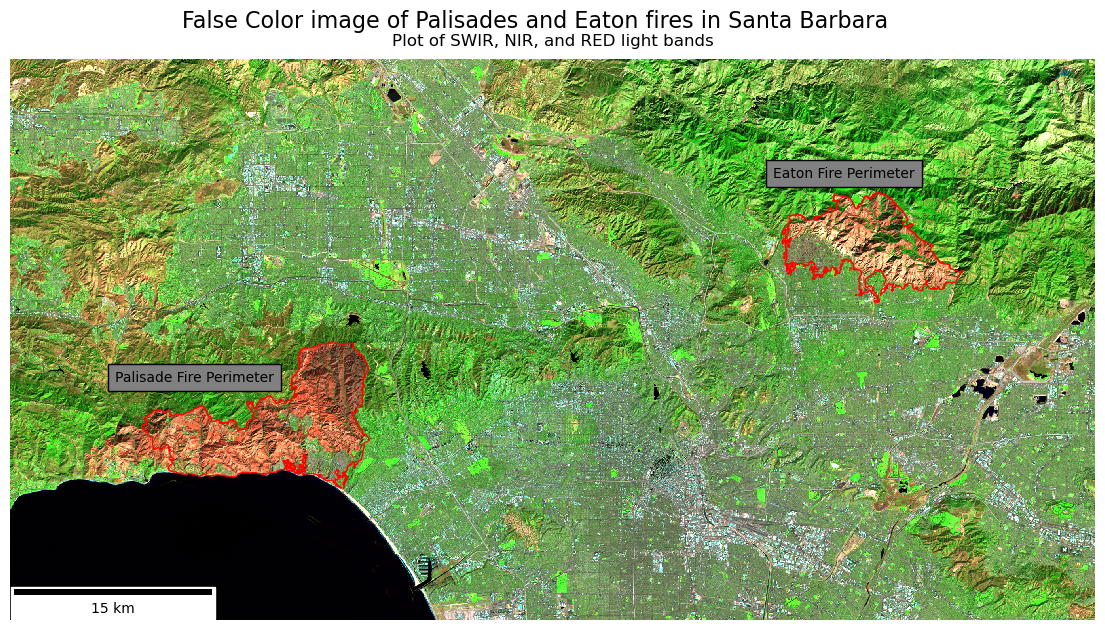

In [91]:
 

fig, ax = plt.subplots(1, 1, figsize = (14,12)) # Set a size for our figure

netcdf[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True, ax = ax) # Choose false color bands

eaton_perimeter.plot(ax = ax, color = 'none', edgecolor = 'red') # Plot Eaton fire perimeter in red

palisades_perimeter.plot(ax = ax, color = 'none', edgecolor = 'red') # And the Palisade perimeter


plt.suptitle('False Color image of Palisades and Eaton fires in Santa Barbara', 
             fontsize=16, 
             y = .77) # This y was a lot of guess and checking 
plt.title("Plot of SWIR, NIR, and RED light bands", 
          fontsize=12, 
          y=1.01) # Title defaults inside the plot and I want it just above, hence 1.01



plt.figtext(x = .2, # The position of the figtext, In units of 0-1 for x and y 
            y = .46,
            s = 'Palisades Fire Perimeter',
            color = 'black',
            bbox ={'facecolor':'grey',  # Add a box around text for legibility 
                   'alpha':1, 'pad':5}) 
plt.figtext(x = .67, 
            y = .63, 
            s= 'Eaton Fire Perimeter',
            color = 'black',
           bbox ={'facecolor':'grey', 
                   'alpha':1, 'pad':5})

ax.add_artist(ScaleBar(1, dimension="si-length", units="m", location="lower left")) # Add a scale bar on the lower left

ax.axis('off') # Turn Axes off

plt.show() # Show plot only 